# 개체명 인식

    개체명 인식을 사용하면 코퍼스로부터 어떤 단어가 
    사람,장소,조직 등을 의미하는 단어인지 찾을 수있다.
    
    ex) 상혁이는 2021년에 구글에 입사했다.
        사람,조직,시간에 대해 개체명 인식 수행하면. 
        (상혁,사람) , (2021년,시간) , (구글,조직)

## NLTK 를 이용한 개체명 인식
    
    NLTK 에서는 개체명 인식기인 'nltk.ne_chunk' 지원한다.
    ne.chunk 로 개체명 인식을 하기 위해선 품사 태깅이 선행되어야 한다.

In [2]:
from nltk import word_tokenize, pos_tag, ne_chunk

sent = "James is working at Disney in London"
sent = pos_tag(word_tokenize(sent))

# 토큰화 + 품사 태깅
print(sent) 

# 개체명 인식
print(ne_chunk(sent))

[('James', 'NNP'), ('is', 'VBZ'), ('working', 'VBG'), ('at', 'IN'), ('Disney', 'NNP'), ('in', 'IN'), ('London', 'NNP')]
(S
  (PERSON James/NNP)
  is/VBZ
  working/VBG
  at/IN
  (ORGANIZATION Disney/NNP)
  in/IN
  (GPE London/NNP))


## 개체명 인식의 BIO 표현 이해하기
    
    개체명 인식은 챗봇 등에서 필요로 하는 주요 전처리 작업.
    
    목적에 특화되도록 개체명 인식을 정확하게 하는 방법 중 하나
    직접 목적에 맞는 데이터를 준비하여 모델을 만드는 방법. -> Bi-LSTM 사용해서 실습.
    
    BIO 표현
        B : Begin, 개체명 시작되는 부분
        I : Inside, 개체명의 내부 부분
        O : Outside, 개체명이 아닌 부분
        ex) 해리포터보러가자 -> (해,B) , (리,I) , (포,I) , (터,I) , (보,O) ... 
            + 개체명 함께 태깅 -> (해,B-영화) , (리,I-영화) , ... 

### 1. 개체명 인식 데이터

    CONLL2003은 개체명 인식을 위한 전통적인 영어 데이터 셋.
    다운로드 링크 : https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/neuroner/data/conll2003/en/train.txt
    
    데이터 형식은 [단어][품사][청크][개체명] 으로 이루어져있다.
    빈 줄은 문장의 구분을 의미한다.

In [4]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/neuroner/data/conll2003/en/train.txt",
                          filename='train.txt')

('train.txt', <http.client.HTTPMessage at 0x165514640>)

In [12]:
import re

fopen = open('train.txt','r')
tagged_sents = []
sent = []

# 단어와 개체명만 저장.
for line in fopen :
    if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n" :
        if len(sent) > 0 :
            tagged_sents.append(sent)
            sent = []
        continue
    # 공백으로 구분 + \n 제거 , 단어(소문자)와 개체명 저장. 
    splits = line.split(" ")
    splits[-1] = re.sub(r"\n","",splits[-1]) 
    word = splits[0].lower()
    sent.append([word,splits[-1]])

In [13]:
print("total samples size : ",len(tagged_sents))
print(tagged_sents[0])

total samples size :  14041
[['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


In [16]:
# 단어 와 개체명을 분리해서 저장.
# 품사 태깅과 동일.

sents , ner_tags = [],[]

for tagged_sent in tagged_sents : 
    
    sent , ner_tag = zip(*tagged_sent)

    sents.append(list(sent))
    ner_tags.append(list(ner_tag))
    
print(sents[0])
print(ner_tags[0])

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


max length of samples :  113
mean length of samples :  14.501887329962253


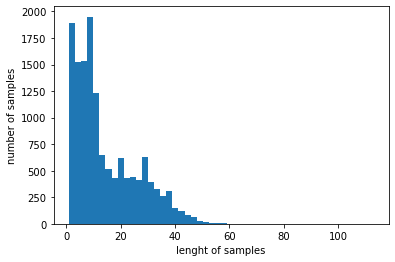

In [20]:
import matplotlib.pyplot as plt

maxlen = max(len(sent) for sent in sents)
meanlen = (sum(map(len,sents)) / len(sents))

print("max length of samples : ",maxlen)
print("mean length of samples : ",meanlen)


plt.hist([len(sent) for sent in sents],bins=50)
plt.xlabel("lenght of samples")
plt.ylabel("number of samples")
plt.show()

In [21]:
# 토큰화 + 정수 인코딩
# 문장 데이터는 4,000 개 단어만 사용.

from tensorflow.keras.preprocessing.text import Tokenizer
max_words = 4000
sent_tokenizer = Tokenizer(num_words=max_words,oov_token='OOV')
sent_tokenizer.fit_on_texts(sents)

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(ner_tags)

X = sent_tokenizer.texts_to_sequences(sents)
y = tag_tokenizer.texts_to_sequences(ner_tags)

In [22]:
# 단어 집합 크기 , 개체명 데이터 크기

vocab_size = max_words
tag_size = len(tag_tokenizer.word_index) + 1
print("vocabulary size : ",vocab_size)
print("tag size : ",tag_size)

vocabulary size :  4000
tag size :  10


In [23]:
# 길이를 70으로 패딩 + 데이터 분리 및 원-핫 인코딩
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 70
X = pad_sequences(X,maxlen=max_len)
y = pad_sequences(y,maxlen=max_len)

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                        test_size=0.2,random_state=777)

y_train = to_categorical(y_train,num_classes=tag_size)
y_test = to_categorical(y_test,num_classes=tag_size)

In [24]:
# 각 데이터 크기

print("train sentences size : ",X_train.shape)
print("train tag size :",y_train.shape)
print("test sentences size : ",X_test.shape)
print("test tag size :",y_test.shape)

train sentences size :  (11232, 70)
train tag size : (11232, 70, 10)
test sentences size :  (2809, 70)
test tag size : (2809, 70, 10)


### 2. Bi-LSTM 개체명 인식기

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Bidirectional,TimeDistributed

model = Sequential()
model.add(Embedding(vocab_size,128,input_length=max_len,mask_zero=True))
model.add(Bidirectional(LSTM(256,return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size,activation='softmax')))

In [26]:
model.compile(optimizer='adam',loss='categorical_crossentropy',
              metrics=['acc'])

model.fit(X_train,y_train,batch_size=128,epochs=8,
          validation_data=(X_test,y_test))

Epoch 1/8
88/88 [==============================] - 84s 917ms/step - loss: 0.2539 - acc: 0.7949 - val_loss: 0.1232 - val_acc: 0.8339
Epoch 2/8
88/88 [==============================] - 76s 867ms/step - loss: 0.1091 - acc: 0.8434 - val_loss: 0.0747 - val_acc: 0.8911
Epoch 3/8
88/88 [==============================] - 76s 861ms/step - loss: 0.0712 - acc: 0.8977 - val_loss: 0.0513 - val_acc: 0.9276
Epoch 4/8
88/88 [==============================] - 76s 864ms/step - loss: 0.0477 - acc: 0.9342 - val_loss: 0.0404 - val_acc: 0.9426
Epoch 5/8
88/88 [==============================] - 79s 896ms/step - loss: 0.0352 - acc: 0.9509 - val_loss: 0.0350 - val_acc: 0.9507
Epoch 6/8
88/88 [==============================] - 77s 881ms/step - loss: 0.0270 - acc: 0.9611 - val_loss: 0.0334 - val_acc: 0.9540
Epoch 7/8
88/88 [==============================] - 76s 864ms/step - loss: 0.0240 - acc: 0.9659 - val_loss: 0.0339 - val_acc: 0.9554
Epoch 8/8
88/88 [==============================] - 85s 966ms/step - loss: 0.

In [28]:
print(f"model accuracy : {round(model.evaluate(X_test,y_test)[1],3)}")

88/88 [==============================] - 10s 117ms/step - loss: 0.0320 - acc: 0.9566
model accuracy : 0.957


In [33]:
import numpy as np

idx_to_word = sent_tokenizer.index_word
idx_to_ner = tag_tokenizer.index_word

y_pred = model.predict(np.array([X_test[10]]))
y_pred = np.argmax(y_pred,-1)
y_true = np.argmax(y_test[10],-1)

print("{:15}|{:5}|{}".format("단어","실제값","예측값"))
print("-" * 35)

for w , true , pred in zip(X_test[10],y_true,y_pred[0]) :
    if w != 0 :
        print("{:17}:{:7} {}".format(idx_to_word[w],idx_to_ner[true].upper(),
                                    idx_to_ner[pred].upper()))



단어             |실제값  |예측값
-----------------------------------
sarah            :B-PER   B-PER
brady            :I-PER   I-PER
,                :O       O
whose            :O       O
republican       :B-MISC  B-MISC
husband          :O       O
was              :O       O
OOV              :O       O
OOV              :O       O
in               :O       O
an               :O       O
OOV              :O       O
attempt          :O       O
on               :O       O
president        :O       O
ronald           :B-PER   B-PER
reagan           :I-PER   I-PER
,                :O       O
took             :O       O
centre           :O       O
stage            :O       O
at               :O       O
the              :O       O
democratic       :B-MISC  B-MISC
national         :I-MISC  I-MISC
convention       :I-MISC  I-MISC
on               :O       O
monday           :O       O
night            :O       O
to               :O       O
OOV              :O       O
president        :O       O
bill  

출력 결과는 그럴듯해 보이지만 이번에 사용한 정확도 측정 방법이 그다지 적절하지 않다.

-> 예측 정확도가 대부분 'O' 로 인해 결정되기 때문.


=> 해결방법 중 하나인 F1-score 도입(다음 챕터에서 계속)